* Explore Data
* Feature extraction
* Training Classifier
* scroll window to analysis image

## Explore Data


In [67]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import random
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

def load_files(start_dir,files,suffix):
    for dr,_,_ in os.walk(start_dir):
        files.extend(glob.glob(os.path.join(dr,suffix)))        
    return files

def load_data(start_path,suffix='*.png'):
    files=[]
    imgs=[]
    suffix='*.png'
    files=load_files(start_path,files,suffix)
    for filename in files:
        imgs.append(cv2.imread(filename))
    return files,imgs

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    
    test_image = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape 
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    
    return data_dict

In [68]:
def display_image(img, title):
    plt.title(title)
    plt.imshow(img)
    plt.show()

In [59]:
glob.__file__

'/Users/hubing/anaconda/lib/python3.6/glob.py'

In [60]:


vechince_file,vechicle_images=load_data('data/vehicles')
nonvechince_file,nonvechicle_images=load_data('data/non-vehicles')
print(len(vechicle_images))
print(len(nonvechicle_images))

#load_data('data/vehicles_smallset/cars1','.jpeg')
#load_data('data/non-vehicles_smallset/notcars1','.jpeg')

8792
8968


In [62]:
data_info=data_look(vechicle_images,nonvechicle_images)

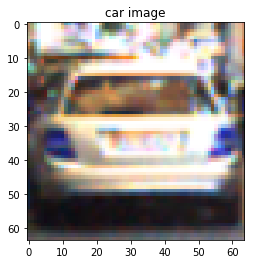

In [69]:
display_image(vechicle_images[random.randint(0, data_info['n_cars'])], 'car image')


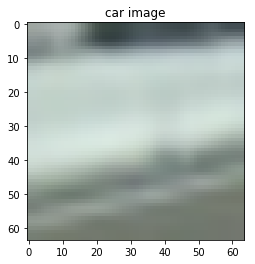

In [70]:
display_image(nonvechicle_images[random.randint(0, data_info['n_notcars'])], 'car image')
